In [6]:
import pandas as pd
import geopandas as gpd

import warnings
warnings.simplefilter(action='ignore')

In [7]:
df = pd.read_csv("../00_data/13_final/cbsa_level.csv")

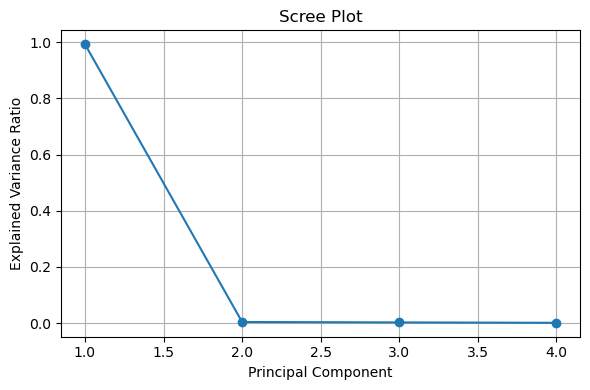

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define factor list and include cbsacode
my_factors = ['DIABETES', 'OBESITY', 'BINGE', 'CSMOKING']
cols_to_use = ['cbsacode'] + my_factors

# Step 2: Subset the dataframe
df_pca = df[cols_to_use].copy()

# Step 3: Drop rows with missing values in selected columns
df_pca = df_pca.dropna(subset=my_factors)

# Step 4: Standardize factor columns only
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca[my_factors])

# Step 5: Run PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 6: Store PCA results in a new DataFrame with cbsacode
pca_result = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_result['cbsacode'] = df_pca['cbsacode'].values

# Step 7: Reorder columns if needed
pca_result = pca_result[['cbsacode'] + [f'PC{i+1}' for i in range(X_pca.shape[1])]]

# Step 8: Explained variance (optional summary)
explained_variance = pd.DataFrame({
    "Principal Component": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    "Explained Variance Ratio": pca.explained_variance_ratio_
})

# Step 9: Scree plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
pca_result

,cbsacode,PC1,PC2,PC3,PC4
0,10100.0,-0.569183,0.030276,0.004369,0.004785
1,10140.0,-0.496074,0.014266,0.014760,0.006016
2,10180.0,-0.286219,0.010041,0.004305,-0.001384
3,10220.0,-0.564598,0.008699,0.014355,0.003161
4,10300.0,-0.446266,0.001742,-0.001943,0.011742
...,...,...,...,...,...
870,49660.0,0.366315,-0.171696,0.011586,-0.069901
871,49700.0,-0.292500,0.007438,0.003456,-0.020499
872,49740.0,-0.215403,-0.000388,0.047487,0.039451
873,49780.0,-0.453444,0.000094,0.009038,-0.003196


In [10]:
gdf = gpd.read_file("../00_data/01_raw/tl_2024_us_cbsa", engine="pyogrio")
gdf['cbsacode'] = gdf['CBSAFP'].astype('float64')
gdf_ll = gdf.to_crs("EPSG:4326").copy()
gdf_ll["centroid"] = gdf_ll.geometry.centroid  # may warn; matches old coordinates exactly
gdf_ll["lon"] = gdf_ll.centroid.x
gdf_ll["lat"] = gdf_ll.centroid.y

df_check = pca_result.merge(gdf_ll[['cbsacode','lon','lat']],how='left')

In [11]:
import numpy as np
from esda.moran import Moran


# ---------------------------
# Safe centroids (projected)
# ---------------------------
def add_lonlat_centroids(gdf, proj_crs="EPSG:5070"):
    """
    Compute centroids in a projected CRS, then bring them back to WGS84.
    """
    gdf_proj = gdf.to_crs(proj_crs).copy()
    cent_proj = gdf_proj.geometry.centroid  # planar centroid in meters
    cent_wgs = gpd.GeoSeries(cent_proj, crs=proj_crs).to_crs("EPSG:4326")
    out = gdf.copy()
    out["centroid"] = cent_wgs
    out["lon"] = cent_wgs.x
    out["lat"] = cent_wgs.y
    return out

# ---------------------------------------
# Fast kNN weights 
# ---------------------------------------

def construct_knn_weights(coords, k):
    # coords: (n,2) [lon, lat] in degrees
    R = 6371.0
    lon = np.radians(coords[:,0])[:,None]  # (n,1)
    lat = np.radians(coords[:,1])[:,None]  # (n,1)

    dlon = lon.T - lon                     # (n,n)
    dlat = lat.T - lat                     # (n,n)

    a = (np.sin(dlat/2.0)**2
         + np.cos(lat) @ np.cos(lat).T * np.sin(dlon/2.0)**2)
    c = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
    dist_mat = R * c
    np.fill_diagonal(dist_mat, np.inf)     # exclude self exactly like before

    n = dist_mat.shape[0]
    W = np.zeros((n,n), dtype=float)
    # identical neighbor selection and weights
    for i in range(n):
        row = dist_mat[i].copy()
        knn_idx = np.argsort(row)[:k]      # same (default quicksort) behavior
        thr = row[knn_idx[-1]]
        if thr > 0:
            W[i, knn_idx] = 1.0 - (dist_mat[i, knn_idx] / thr)

    W_sym = (W + W.T) / 2.0
    row_sums = W_sym.sum(axis=1, keepdims=True)
    nz = row_sums[:,0] > 0
    W_sym[nz] /= row_sums[nz]
    return W_sym

In [14]:
from libpysal.weights.util import full2W

coords_all = df_check[["lon", "lat"]].to_numpy()
W_sym_k = construct_knn_weights(coords_all, k=6)
W_lps_sub = full2W(W_sym_k);  W_lps_sub.transform = 'r'

MI_b = Moran(pca_result['PC1'], W_lps_sub)
b_I, b_p = MI_b.I, MI_b.p_sim

In [15]:
b_I

0.05518602956180173

In [16]:
b_p

0.038